<a href="https://colab.research.google.com/github/arjan-hada/nuclease-design-vae/blob/main/01_ESM_IF1_nucB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating protein sequences from their backbone atom coordinates with ESM-IF1

In this notebook, we will use ESM-IF1 inverse folding model for predicting protein sequences from their backbone atom coordinates.

**Goals**
- Sample sequence designs for a given structure.
- Score the conditional log-likelihoods for sequences conditioned on a given structure.

**Rationale**

In the next notebook, we will be building a generative unsupervised latent variable model for protein sequences - Variational AutoEncoder (VAE). We want to generate test data set for model validation. We will do so by creating our own simulated homologous set of sequences. The premise is that homologous sequences are characterized by a shared protein structure backbone. By leveraging this concept in reverse, we can start with a protein structure backbone and computationally generate sequences predicted to fold into this predetermined structure backbone. The ESM-IF1 inverse folding model generates sequences that are likely to fold into a predetermined structure backbone along with a log likelihood score of doing so.

We will examine the correlation between the log likelihood scores of the simulated homology sequences as generated by our VAE and those produced by the inverse folding model. The VAE itself will be trained on multiple sequence alignment of natural homologs.



## Setup

In [ ]:
# Colab environment setup

# Install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install -q torch-geometric

# Install esm
!pip install -q git+https://github.com/facebookresearch/esm.git

# Install biotite
!pip install -q biotite==0.41.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 54.7 MB/s eta 0:00:00


In [ ]:
import biotite
print(biotite.__version__)

0.41.2


In [ ]:
!pip install -q py3Dmol biopython Levenshtein

In [ ]:
## Verify that pytorch-geometric is correctly installed
import torch_geometric
import torch_sparse
from torch_geometric.nn import MessagePassing

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context="paper", font_scale=1.5)

Inverse folding code from [Inverse folding with ESM-IF1]( https://github.com/facebookresearch/esm/blob/main/examples/inverse_folding/notebook.ipynb).

## Load structure from PDB files

In [ ]:
!wget https://files.rcsb.org/download/5OMT.pdb -P data/

--2024-09-12 16:42:52--  https://files.rcsb.org/download/5OMT.pdb
Resolving files.rcsb.org (files.rcsb.org)... 128.6.159.245
Connecting to files.rcsb.org (files.rcsb.org)|128.6.159.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘data/5OMT.pdb.3’

5OMT.pdb.3              [    <=>             ] 179.64K   280KB/s    in 0.6s    

2024-09-12 16:42:53 (280 KB/s) - ‘data/5OMT.pdb.3’ saved [183951]



In [ ]:
# Look at first 10 lines of pdb file
!head -n 10 data/5OMT.pdb

HEADER    HYDROLASE                               01-AUG-17   5OMT              
TITLE     ENDONUCLEASE NUCB                                                     
COMPND    MOL_ID: 1;                                                            
COMPND   2 MOLECULE: NUCB;                                                      
COMPND   3 CHAIN: A;                                                            
COMPND   4 ENGINEERED: YES                                                      
SOURCE    MOL_ID: 1;                                                            
SOURCE   2 ORGANISM_SCIENTIFIC: BACILLUS LICHENIFORMIS;                         
SOURCE   3 ORGANISM_TAXID: 1402;                                                
SOURCE   4 GENE: NUCB;                                                          


In [ ]:
import py3Dmol

def view_pdb(fpath, chain_id):
    with open(fpath) as ifile:
        system = "".join([x for x in ifile])

    view = py3Dmol.view(width=600, height=400)
    view.addModelsAsFrames(system)
    view.setStyle({'model': -1, 'chain': chain_id}, {"cartoon": {'color': 'spectrum'}})
    view.zoomTo()
    view.show()

In [ ]:
fpath = 'data/5OMT.pdb'
chain_id = ['A', 'B']
view_pdb(fpath, chain_id)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Sample sequence designs for a given structure

### Use the single chain backbone as model input for conditioning

#### Load model

In [ ]:
import esm
model, alphabet = esm.pretrained.esm_if1_gvp4_t16_142M_UR50()
model = model.eval()

/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(


#### Load structure from PDB file

In [ ]:
fpath = 'data/5OMT.pdb'
chain_id = 'A'
structure = esm.inverse_folding.util.load_structure(fpath, chain_id)
coords, native_seq = esm.inverse_folding.util.extract_coords_from_structure(structure)
print(f'Native sequence: {native_seq}')
print(f"length of native sequence: {len(native_seq)}")

Native sequence: ARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ
length of native sequence: 109


#### Sample sequence and calculate sequence recovery

In [ ]:
import numpy as np

sampled_seq = model.sample(coords, temperature=1)
print('Sampled sequence:', sampled_seq)

recovery = np.mean([(a==b) for a, b in zip(native_seq, sampled_seq)])
print('Sequence recovery:', recovery)

print(f"length: {len(sampled_seq)}")

Sampled sequence: DAFDATLTYPAATYPAAGAHIAAAITSGAPAVCTLARAGAAARRDESLAGIPARPGYTRDEWPLALCVEGGTGSSVAYVPAADNQGAGAWMLGTLSAYADGTRILQVVS
Sequence recovery: 0.5504587155963303
length: 109


In [ ]:
# Lower sampling temperature typically results in higher sequence recovery but less diversity
sampled_seq = model.sample(coords, temperature=1e-6)
print('Sampled sequence:', sampled_seq)

recovery = np.mean([(a==b) for a, b in zip(native_seq, sampled_seq)])
print('Sequence recovery:', recovery)

print(f"length: {len(sampled_seq)}")

Sampled sequence: MDYDAVLYFPAATYPEAGAHIKAAIAAGHAAVCTLDRAGAAARRDQSLAGIPARPGYDRDEWPFAICREGGAGSAVRYVPAADNQGAGAWLRNTLAAYADGTRILFVVG
Sequence recovery: 0.6422018348623854
length: 109


The temperature parameter controls the sharpness of the probability distribution for sequence sampling. Higher sampling temperatures yield more diverse sequences but likely with lower native sequence recovery. The default sampling temperature is 1. To optimize for native sequence recovery, ESM-IF1 recommends sampling with low temperature such as 1e-6.

#### Conditional sequence log-likelihoods for given backbone coordinates

The log-likelihood scores could be used to predict mutational effects.

In [ ]:
ll_fullseq, ll_withcoord = esm.inverse_folding.util.score_sequence(model, alphabet, coords, native_seq)

print(f'average log-likelihood on entire sequence: {ll_fullseq:.2f} (perplexity {np.exp(-ll_fullseq):.2f})')
print(f'average log-likelihood excluding missing coordinates: {ll_withcoord:.2f} (perplexity {np.exp(-ll_withcoord):.2f})')

average log-likelihood on entire sequence: -0.99 (perplexity 2.70)
average log-likelihood excluding missing coordinates: -0.99 (perplexity 2.70)


## Batch sample and scoring

In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/esm/main/examples/inverse_folding/sample_sequences.py -P scripts/

--2024-09-12 16:44:18--  https://raw.githubusercontent.com/facebookresearch/esm/main/examples/inverse_folding/sample_sequences.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4505 (4.4K) [text/plain]
Saving to: ‘scripts/sample_sequences.py’

sample_sequences.py 100%[===================>]   4.40K  --.-KB/s    in 0s      

2024-09-12 16:44:19 (73.4 MB/s) - ‘scripts/sample_sequences.py’ saved [4505/4505]



In [ ]:
!wget https://raw.githubusercontent.com/facebookresearch/esm/main/examples/inverse_folding/score_log_likelihoods.py -P scripts/

--2024-09-12 16:44:22--  https://raw.githubusercontent.com/facebookresearch/esm/main/examples/inverse_folding/score_log_likelihoods.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4661 (4.6K) [text/plain]
Saving to: ‘scripts/score_log_likelihoods.py’

score_log_likelihoo 100%[===================>]   4.55K  --.-KB/s    in 0s      

2024-09-12 16:44:22 (70.7 MB/s) - ‘scripts/score_log_likelihoods.py’ saved [4661/4661]



### Sample sequence designs for a given structure

Use backbone of the specified target chain as model input for conditioning.

In [ ]:
!mkdir -p output

In [ ]:
PDBID = '5OMT'
chain = 'A'
temp = 1
nsamples = 500
fname_sampled_seqs = f'data/{PDBID}_{chain}_ESMIF1_{temp}_{nsamples}.fasta'
fname_sampled_seqs

'data/5OMT_A_ESMIF1_1_500.fasta'

In [ ]:
!python scripts/sample_sequences.py data/5OMT.pdb \
    --chain $chain --temperature $temp --num-samples $nsamples \
    --outpath $fname_sampled_seqs

/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Transferred model to GPU
Native sequence loaded from structure file:
ARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ
Saving sampled sequences to data/5OMT_A_ESMIF1_1_500.fasta.

Sampling.. (1 of 500)
Sampled sequence:
AWFDAEWFFPCDRFPESCAQIRQAIALGHAAVCTLDRDGARARNREALAGIPRRPGYERHEWPFSECREGGRGSLVKYVDARDNQGAGRYLRRHLARYANGTKLLGVVK
Sequence recovery: 0.47706422018348627

Sampling.. (2 of 500)
Sampled sequence:
VAFDTTLQFPAAQFPESGQHIQDAIAEGHAAVCTLARQRAWQRRQEALAGIPQRAGYQRHEWPFSICTEGGAGSAVRYVSALDNSGMGSWLRNWLSQYADGTRIRLVVR
Sequence recovery: 0.5504587155963303

Sampling.. (3 of 500)
Sampled sequence:
GIFDATMQQPVAEFPESGKMIKQAIAEGFADVCTLDRAARKERYTQSLKGIPEKPGYDRHEWPFAYCKEGGAGSKVVYVKHDDNQGFGRWLDNHLSKFNDGTRIKQVVK
Sequence recovery: 0.47706422018348627

Sampling.. (4 

### Score sequences

The output values are the average log-likelihoods averaged over all amino acids in a sequence.

In [ ]:
fname_sampled_seqs_score = f'output/{PDBID}_{chain}_ESMIF1_{temp}_{nsamples}_score.csv'
fname_sampled_seqs_score

'output/5OMT_A_ESMIF1_1_500_score.csv'

In [ ]:
!python scripts/score_log_likelihoods.py data/5OMT.pdb \
    data/5OMT_A_ESMIF1_1_500.fasta --chain A \
    --outpath output/5OMT_A_ESMIF1_1_500_score.csv

/usr/local/lib/python3.10/dist-packages/esm/pretrained.py:215: UserWarning: Regression weights not found, predicting contacts will not produce correct results.
  warnings.warn(
Transferred model to GPU
Native sequence loaded from structure file:
ARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ


Native sequence
Log likelihood: -0.99
Perplexity: 2.70

Scoring variant sequences from sequence file..

100% 500/500 [00:26<00:00, 18.95it/s]
Results saved to output/5OMT_A_ESMIF1_1_500_score.csv


In [ ]:
import pandas as pd
sampled_seqs_df = pd.read_csv(fname_sampled_seqs_score)
sampled_seqs_df.head()

,seqid,log_likelihood
0,sampled_seq_1,-1.067197
1,sampled_seq_2,-1.029135
2,sampled_seq_3,-1.038908
3,sampled_seq_4,-1.094937
4,sampled_seq_5,-0.958626


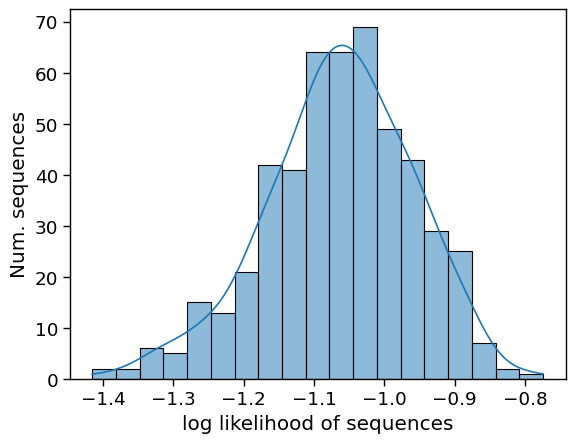

In [ ]:
sns.histplot(sampled_seqs_df.log_likelihood, kde=True)
plt.xlabel('log likelihood of sequences')
plt.ylabel('Num. sequences');

## Sampled sequence -> full length sequence & mutational distance

Get full length sequence of target protein from uniprot.

In [ ]:
import requests
from Bio import SeqIO, Entrez
from io import StringIO

def download_protein_seq(protein_id, output_dir="data"):

    query_url =  f"https://rest.uniprot.org/uniprotkb/{protein_id}.fasta"
    # Download the FASTA file content from the web link
    response = requests.get(query_url)

    if response.status_code == 200:

        # File path for saving the FASTA file
        output_fpath = f"{output_dir}/{protein_id}.fasta"

        # Parse the content using Biopython's SeqIO
        fasta_content = StringIO(response.text)
        refseq = next(SeqIO.parse(fasta_content, 'fasta'))

        # Writing the sequence record to a file
        with open(output_fpath, 'w') as refseq_out:
            SeqIO.write(refseq, refseq_out, "fasta-2line")

        return refseq
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")

In [ ]:
refseq = download_protein_seq("F1BV52")
print(f"Protein Sequence: {refseq.seq}")
print(f"Protein Sequence Length: {len(refseq.seq)}")

Protein Sequence: MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAARYDDVLYFPASRYPETGAHISDAIKAGHADVCTIERSGADKRRQESLKGIPTKPGFDRDEWPMAMCEEGGKGASVRYVSSSDNRGAGSWVGNRLNGYADGTRILFIVQ
Protein Sequence Length: 142


Compare the refseq sequence to native sequence from PDB file.

In [ ]:
def find_missing_sequence(refseq, pdb_seq):
    """
    Find missing sequences in the PDB sequence compared to the reference sequence,
    handling missing parts on both the left and right sides.

    Parameters:
        refseq (str): The reference sequence (full sequence).
        pdb_seq (str): The PDB sequence (possibly missing parts).

    Returns:
        missing_left (str): The missing sequence on the left side of the PDB sequence.
        missing_right (str): The missing sequence on the right side of the PDB sequence.
        start_pos (int): The start position of the PDB sequence in refseq.
    """
    # Make sure both sequences are upper case
    refseq = refseq.upper()
    pdb_seq = pdb_seq.upper()

    # Find where the PDB sequence starts in the reference sequence
    start_pos = refseq.find(pdb_seq)

    if start_pos == -1:
        raise ValueError("PDB sequence is not found within the reference sequence.")

    # Missing on the left: everything before the start of the PDB sequence in the refseq
    missing_left = refseq[:start_pos]

    # Missing on the right: everything after the end of the PDB sequence in the refseq
    end_pos = start_pos + len(pdb_seq)
    missing_right = refseq[end_pos:]

    return missing_left, missing_right, start_pos

In [ ]:
missing_left, missing_right, start_pos = find_missing_sequence(refseq.seq, native_seq)
print(f"Missing sequence on the left: {missing_left}")
print(f"Missing sequence on the right: {missing_right}")
print(f"Start position of the PDB sequence in the reference sequence: {start_pos}")

Missing sequence on the left: MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGA
Missing sequence on the right: 
Start position of the PDB sequence in the reference sequence: 33


Append missing sequences in ESM-IF1 sampled sequences.

In [ ]:
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
def append_missing_sequence_to_fasta(in_path, out_path, missing_left, missing_right):
    """
    Append missing sequences to both sides of each sequence in the FASTA file.

    Parameters:
        in_path (str): Path to the input FASTA file (e.g., ESM-IF1 results).
        out_path (str): Path to the output FASTA file with missing sequence appended.
        missing_left (str): The missing sequence to be appended to the left.
        missing_right (str): The missing sequence to be appended to the right.

    Returns:
        None
    """
    # Load the sequences from the FASTA file
    sequences = list(SeqIO.parse(in_path, "fasta"))

    # Iterate through each sequence and append the missing sequences
    updated_sequences = []
    for record in sequences:
        # Append the missing sequences to the left and right of the original sequence
        new_seq = missing_left + str(record.seq) + missing_right
        updated_record = SeqRecord(Seq(new_seq), id=record.id, description=record.description)
        updated_sequences.append(updated_record)

    # Write the updated sequences to the output FASTA file
    SeqIO.write(updated_sequences, out_path, "fasta")

    print(f"Missing sequences appended and saved to {out_path}")

In [ ]:
fname_sampled_seqs_full = f'output/{PDBID}_{chain}_ESMIF1_{temp}_{nsamples}_full.fasta'
fname_sampled_seqs_full

'output/5OMT_A_ESMIF1_1_500_full.fasta'

In [ ]:
append_missing_sequence_to_fasta(fname_sampled_seqs, fname_sampled_seqs_full,
                                 missing_left, missing_right)

Missing sequences appended and saved to output/5OMT_A_ESMIF1_1_500_full.fasta


In [ ]:
!head -n 10 $fname_sampled_seqs_full

>sampled_seq_1
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAAWFDAEWFFPCDRFPESCAQIRQAIAL
GHAAVCTLDRDGARARNREALAGIPRRPGYERHEWPFSECREGGRGSLVKYVDARDNQGA
GRYLRRHLARYANGTKLLGVVK
>sampled_seq_2
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAVAFDTTLQFPAAQFPESGQHIQDAIAE
GHAAVCTLARQRAWQRRQEALAGIPQRAGYQRHEWPFSICTEGGAGSAVRYVSALDNSGM
GSWLRNWLSQYADGTRIRLVVR
>sampled_seq_3
MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAGIFDATMQQPVAEFPESGKMIKQAIAE


Save full length sampled sequence corresponding log_likelihood, and mutational distance from refernce sequence in csv file.

In [ ]:
from Levenshtein import distance
# Load FASTA file into a dictionary
sampled_seqs_full = {record.id: str(record.seq) for record in SeqIO.parse(fname_sampled_seqs_full, "fasta")}

# Map sequences from FASTA to CSV
sampled_seqs_df['sequence'] = sampled_seqs_df['seqid'].map(sampled_seqs_full)

# Calculate the Levenshtein (edit) distance for each sequence
sampled_seqs_df['num_muts'] = sampled_seqs_df['sequence'].apply(lambda seq:
                                                                distance(seq, refseq.seq))

In [ ]:
sampled_seqs_df.head()

,seqid,log_likelihood,sequence,num_muts
0,sampled_seq_1,-1.067197,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAAWFDAEWFFPCDR...,57
1,sampled_seq_2,-1.029135,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAVAFDTTLQFPAAQ...,49
2,sampled_seq_3,-1.038908,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAGIFDATMQQPVAE...,56
3,sampled_seq_4,-1.094937,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGAMKYDVTWVFPRSK...,52
4,sampled_seq_5,-0.958626,MIKKWAVHLLFSALVLLGLSGGAAYSPQHAEGACNYDAVLYTPCNT...,51


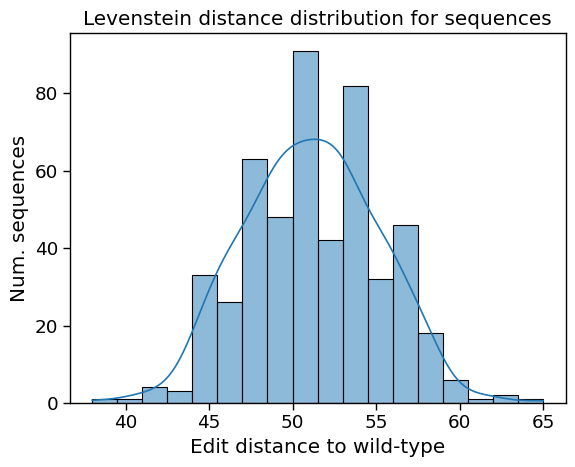

In [ ]:
sns.histplot(sampled_seqs_df['num_muts'].values, kde=True);
plt.xlabel('Edit distance to wild-type')
plt.ylabel('Num. sequences')
plt.title("Levenstein distance distribution for sequences");

In [ ]:
# Save the combined data to a new CSV file
fname_sampled_seqs_df = f'output/{PDBID}_{chain}_ESMIF1_{temp}_{nsamples}_df.csv'
sampled_seqs_df.to_csv(fname_sampled_seqs_df, index=False)